# Imports:

In [1]:
# Makes sure to reload modules when they change
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.amp import GradScaler, autocast
import joblib
from tqdm import tqdm
from PIL import Image, ImageOps

# --- CUSTOM IMPORTS ---
from src.utils import extractCoordinates, aspect_crop, haversine_distance, plot_images_from_dataloader, setup_TensorBoard_writers, log_error_map
from src.dataset import GeolocalizationDataset
from src.models import ConvNet, ConvNet2, ConvNet3

torch.backends.cudnn.benchmark = True

# Image preprocessing:

In [2]:
# Setup paths
RAW_IMAGE_FOLDER = r"data"             # Use original images for GPS extraction
PROCESSED_IMAGE_FOLDER = r"data_processed" # Use processed images for training

if not os.path.exists(PROCESSED_IMAGE_FOLDER) or len(os.listdir(PROCESSED_IMAGE_FOLDER)) < 1479:
    os.makedirs(PROCESSED_IMAGE_FOLDER, exist_ok=True)

    print("Starting Pre-processing...")
    files = [f for f in os.listdir(RAW_IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg'))]

    for filename in tqdm(files):
        src_path = os.path.join(RAW_IMAGE_FOLDER, filename)
        dst_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
        
        try:
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                img = img.convert('RGB')
                img = aspect_crop(img) 
                img = img.resize((192, 256), Image.Resampling.LANCZOS)
                img.save(dst_path, quality=95)
        except Exception as e:
            print(f"Failed {filename}: {e}")
else:
    print("Pre-processed images already exist. Skipping preprocessing step.")

Pre-processed images already exist. Skipping preprocessing step.


# Data loading:

In [3]:
if __name__ == "__main__":

    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'

    # --- 2. EXTRACTION PHASE ---
    processed_data = []

    for filename in os.listdir(RAW_IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            raw_image_path = os.path.join(RAW_IMAGE_FOLDER, filename)
            processed__image_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
            
            # Check if the processed version actually exists
            if not os.path.exists(processed__image_path):
                continue
                
            # Extract coordinates from the ORIGINAL file
            coords = extractCoordinates(raw_image_path)
            
            if coords:
                processed_data.append({
                    'path': processed__image_path, 
                    'lat': coords[0], 
                    'lon': coords[1]
                })

    df = pd.DataFrame(processed_data)
    
    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # --- 3. SCALING PHASE ---
    # must fit on training data *only*
    scaler = MinMaxScaler()
    train_df[['lat', 'lon']] = scaler.fit_transform(train_df[['lat', 'lon']])
    val_df[['lat', 'lon']] = scaler.transform(val_df[['lat', 'lon']])

    joblib.dump(scaler, SCALER_SAVE_PATH)

Initializing train dataset...
Caching 1183 images in RAM...


100%|██████████| 1183/1183 [00:01<00:00, 609.70it/s]


Initializing validation dataset...
Caching 296 images in RAM...


100%|██████████| 296/296 [00:00<00:00, 647.43it/s]


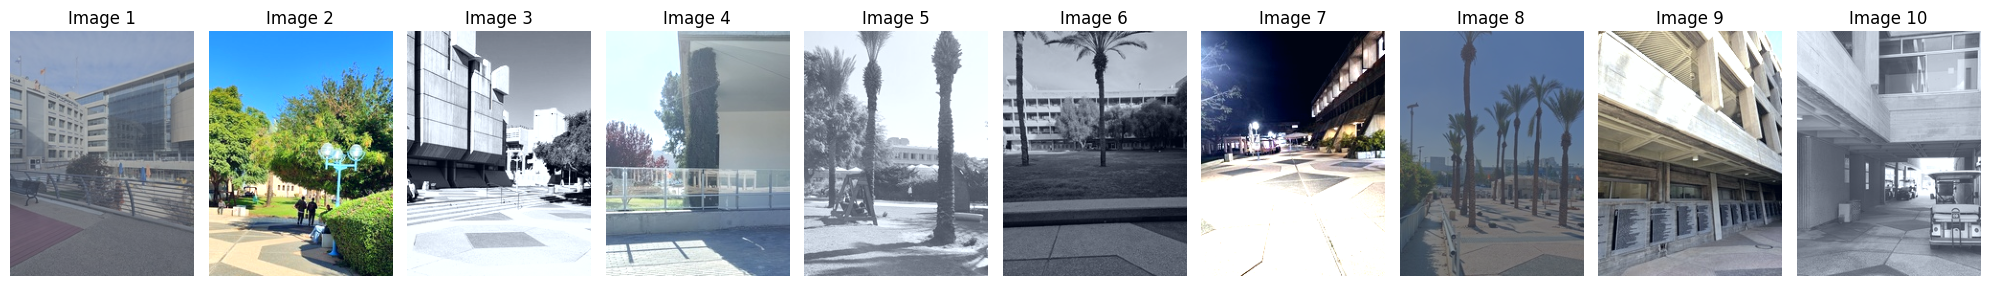

In [11]:
if __name__ == "__main__":

    # --- 4. DATASET INITIALIZATION ---
    print("Initializing train dataset...")
    train_dataset = GeolocalizationDataset(
        image_paths=train_df['path'].tolist(),
        coordinates=train_df[['lat', 'lon']].values,
        is_train=True
    )
    print("Initializing validation dataset...")
    val_dataset = GeolocalizationDataset(
        image_paths=val_df['path'].tolist(),
        coordinates=val_df[['lat', 'lon']].values,
        is_train=False
    )

    # --- 5. THE DATALOADER ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=0, 
        pin_memory=True)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=0, 
        pin_memory=False)
    
    plot_images_from_dataloader(train_loader)

# Model setup:

In [17]:
# --- 6. INITIALIZE MODEL ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_rtx = "RTX" in torch.cuda.get_device_name(0)
print("Using device:", device)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

model = ConvNet2(use_dropout=True).to(device)

if is_rtx:
    model = model.to(memory_format=torch.channels_last) # Optimize for modern GPUs that prefer channels_last
else:
    print("RTX card not detected: Disabling AMP/Channels_Last optimizations")
    model = model.to(device)

# --- 7. LOSS & OPTIMIZER ---
patience_counter = 0
early_stopping_patience = 10
epochs = 100
use_TensorBoard = True # Set to False to disable TensorBoard logging

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1e-3, 
    steps_per_epoch=len(train_loader), 
    epochs=epochs,
    pct_start=0.3, # Spend 30% of time warming up
    div_factor=25, # Start at max_lr / 25
    final_div_factor=1e4 # End at max_lr / 10000
)

print(f"Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images.")

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce GTX 1070
RTX card not detected: Disabling AMP/Channels_Last optimizations
Training on 1183 images, Validating on 296 images.


# Model training:

In [ ]:
# --- 8. TRAINING & VALIDATION LOOP ---
train_losses = []
val_losses = []
val_dist_history = []
learning_rates = []
best_dist = float("inf")

if use_TensorBoard:
    writer_train, writer_val = setup_TensorBoard_writers()

print(f"Starting training on {device}...")

gradScaler = GradScaler('cuda') #scaler for mixed precision training, prevents gradient underflow

for epoch in range(epochs):
    # --- PHASE 1: TRAINING ---
    model.train()  # Dropout ON
    train_running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False, unit="batch", mininterval=0.5)
    
    for images, labels in pbar:
        # non_blocking=True speeds up RAM-to-VRAM transfer
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        if is_rtx: # Optimize for RTX GPUs that prefer channels_last
            images = images.to(memory_format=torch.channels_last)

        optimizer.zero_grad(set_to_none=True)

        if is_rtx: # Use Mixed Precision Training only on RTX cards
            with autocast('cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            gradScaler.scale(loss).backward() 
            gradScaler.step(optimizer)        
            gradScaler.update()  

        else: # Standard training for non-RTX cards
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        scheduler.step() # OneCycleLR steps after every batch
        train_running_loss += loss.item()

    # --- PHASE 2: VALIDATION ---
    model.eval()  # Set model to evaluation mode (disables Dropout)
    val_running_loss = 0.0
    total_distance = 0.0
    correct_50m = 0
    total_samples = 0
    raw_preds = []
    raw_trues = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in val_loader:
            #todo: channels last?
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # Standard Prediction and MSE Loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            raw_preds.append(outputs.cpu().numpy())
            raw_trues.append(labels.cpu().numpy())

    full_preds_raw = np.vstack(raw_preds)
    full_trues_raw = np.vstack(raw_trues)

    real_preds = scaler.inverse_transform(full_preds_raw)
    real_trues = scaler.inverse_transform(full_trues_raw)


    # --- PHASE 3: METRICS CALCULATION & PRINTING ---
    distances = haversine_distance(real_preds, real_trues)
    avg_dist_error = np.mean(distances)
    
    avg_train_loss = train_running_loss / len(train_loader)
    avg_val_loss = val_running_loss / len(val_loader)
    current_lr = scheduler.get_last_lr()[0]

    if epoch % 15 == 0: # log error map every 15 epochs
        log_error_map(real_preds, real_trues, epoch, TB_writer = writer_val if use_TensorBoard else None)

    if use_TensorBoard:     # Write to TensorBoard
        writer_train.add_scalar('MSE Loss', avg_train_loss, epoch)
        writer_val.add_scalar('MSE Loss', avg_val_loss, epoch)
        writer_val.add_scalar('Distance (Meters)', avg_dist_error, epoch)
        writer_train.add_scalar('Hyperparameters/Learning_Rate', current_lr, epoch)

    else: # No TensorBoard: store in lists
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_dist_history.append(avg_dist_error)
        learning_rates.append(current_lr)
    
    print(f"Epoch {epoch+1}: Val Loss {avg_val_loss:.4f} | Dist Error {avg_dist_error:.1f}m")

    # 2. Save the BEST version of YOUR model
    if avg_dist_error < best_dist:
        best_dist = avg_dist_error
        torch.save(model.state_dict(), "custom_geo_model_best.pth")
        patience_counter = 0
        print(f"  *** NEW BEST: {best_dist:.1f}m ***")
    else:
        patience_counter += 1
        print(f"(No improvement for {patience_counter}/{early_stopping_patience} epochs)")
         # 3. Early Stopping check
        if patience_counter >= early_stopping_patience:
            print("Model stopped improving. Ending training early.")
            break 

log_error_map(real_preds, real_trues, epoch, TB_writer = writer_val if use_TensorBoard else None) # final log

if use_TensorBoard:
    writer_train.close()
    writer_val.close()

Tensorboard - Logging to: runs/experiment_20260107_215207
Starting training on cuda...


Epoch 1/100:  80%|████████  | 8/10 [00:08<00:02,  1.11s/batch]

# Plotting the results:

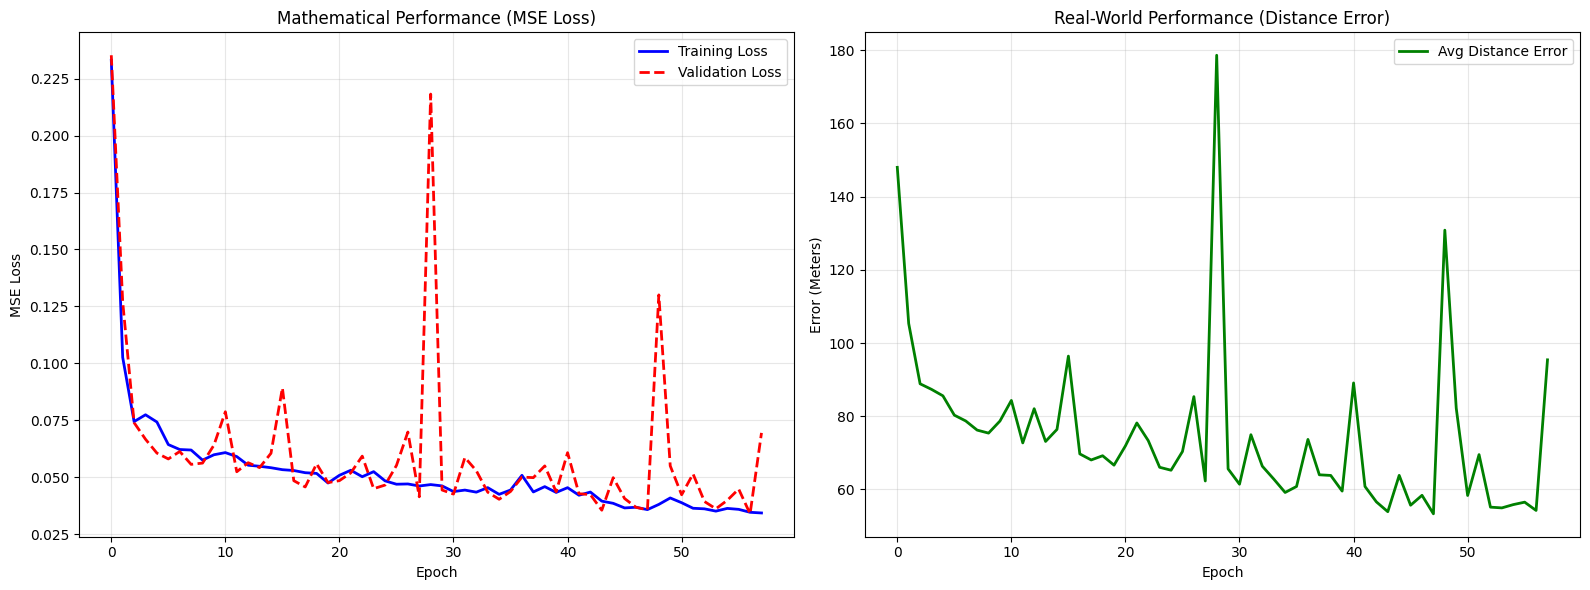


Training finished! Best Validation Error: 53.3 meters.
Model saved as 'geo_model.pth'


In [16]:
# --- 9. SAVE THE MODEL & GENERATE PLOTS ---

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: MSE Loss (Training vs Validation)
ax1.plot(train_losses, label="Training Loss", color="blue", linewidth=2)
ax1.plot(val_losses, label="Validation Loss", color="red", linestyle="--", linewidth=2)
ax1.set_title("Mathematical Performance (MSE Loss)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right Plot: Physical Distance Error (Meters)
ax2.plot(val_dist_history, label="Avg Distance Error", color="green", linewidth=2)
ax2.set_title("Real-World Performance (Distance Error)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Error (Meters)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the model weights
torch.save(model.state_dict(), "geo_model.pth")
print(f"\nTraining finished! Best Validation Error: {best_dist:.1f} meters.")
print("Model saved as 'geo_model.pth'")

In [15]:
""" # Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALER_PATH = 'coordinate_scaler.pkl'
MODEL_WEIGHTS_PATH = 'geo_model.pth'

# Loading Model and Scaler
# Initialize the model architecture and move to the device (GPU/CPU)
model = ConvNet2().to(device)

# Load the trained weights from the .pth file
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

# Set the model to evaluation mode (disables Dropout and Batchnorm layers)
model.eval()

# Load the MinMaxScaler used during training to reverse the normalization
scaler = joblib.load(SCALER_PATH)

# Image Preprocessing Function
def predict_location(image_path):

    # Load the image and ensure it is in RGB format
    img = Image.open(image_path).convert('RGB')
    
    # Apply the same validation transforms (No augmentations here!)
    preprocess = T.Compose([
        T.Resize(256),
        T.CenterCrop(256),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Add a batch dimension (Batch size of 1) and move the tensor to device
    img_tensor = preprocess(img).unsqueeze(0).to(device) 
    
    # Perform inference without calculating gradients
    with torch.no_grad():
        output = model(img_tensor)
    
    # Convert the prediction back to a NumPy array on the CPU
    prediction_normalized = output.cpu().numpy()
    
    # Reverse the scaling to get real-world GPS coordinates
    real_coords = scaler.inverse_transform(prediction_normalized)
    
    # Return the first (and only) result in the batch [Latitude, Longitude]
    return real_coords[0]

# Run Inference on a New Image
# Provide the full path to your local image file
test_path = r"C:\path\to\your\new\image.jpg"
lat, lon = predict_location(test_path)

print(f"Predicted Location: Latitude {lat:.6f}, Longitude {lon:.6f}")
print(f"Google Maps Link: http://maps.google.com/maps?q={lat},{lon}") """

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\013ri\AppData\Local\Temp\ipykernel_9140\333207449.py:1: SyntaxWarning: invalid escape sequence '\p'
  """ # Check if GPU is available, otherwise use CPU


' # Check if GPU is available, otherwise use CPU\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nSCALER_PATH = \'coordinate_scaler.pkl\'\nMODEL_WEIGHTS_PATH = \'geo_model.pth\'\n\n# Loading Model and Scaler\n# Initialize the model architecture and move to the device (GPU/CPU)\nmodel = ConvNet2().to(device)\n\n# Load the trained weights from the .pth file\nmodel.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))\n\n# Set the model to evaluation mode (disables Dropout and Batchnorm layers)\nmodel.eval()\n\n# Load the MinMaxScaler used during training to reverse the normalization\nscaler = joblib.load(SCALER_PATH)\n\n# Image Preprocessing Function\ndef predict_location(image_path):\n\n    # Load the image and ensure it is in RGB format\n    img = Image.open(image_path).convert(\'RGB\')\n\n    # Apply the same validation transforms (No augmentations here!)\n    preprocess = T.Compose([\n        T.Resize(256),\n        T.CenterCrop(256),\n        T.ToTensor(),\n        